In [49]:
import os
import pypsa
import calendar
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import geopandas as gpd
import seaborn as sns

from pathlib import Path
from copy import deepcopy

from region_grouper import coarse_regions

In [104]:
data_path = Path.cwd().parent.parent.parent / "cluster_data"

regions = gpd.read_file(data_path / "resources" / "regions_onshore_elec_s_72.geojson")
regions = regions.set_index("name")
regions["name"] = regions.index


def dict_list(dict):
    aslist = list()
    for value in dict.values():
        aslist += value

    return aslist


def make_region_mapper():

    result = deepcopy(coarse_regions)
    covered = dict_list(result)

    for bus in regions.index:

        if bus in covered:
            continue

        result[pycountry.countries.get(alpha_2=bus[:2]).name] = [bus]

    return result

mapper = make_region_mapper()
reverse_mapper = dict()

for key, values in mapper.items():
    for value in values:
        reverse_mapper[value] = key

model1 = pypsa.Network(
    data_path / 
    "chp_data" / 
    "elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2030_2500_chp_flex_0.3.nc"
)
model2 = pypsa.Network(
    data_path / 
    "chp_data" / 
    "elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2030_2500_chp_flex_0.3.nc"
)

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2030_2500_chp_flex_0.3.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2030_2500_chp_flex_0.3.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [114]:
# plot_regions = list(mapper)
plot_regions = ["Central Germany"]

buses = list()
for region in plot_regions:
    buses += mapper[region]

In [109]:
model1.links.carrier.unique()

array(['DC', 'OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'battery charger',
       'battery discharger', 'Sabatier', 'SMR CC', 'SMR', 'BEV charger',
       'V2G', 'residential rural ground heat pump',
       'residential rural water tanks charger',
       'residential rural water tanks discharger',
       'residential rural resistive heater',
       'residential rural gas boiler', 'services rural ground heat pump',
       'services rural water tanks charger',
       'services rural water tanks discharger',
       'services rural resistive heater', 'services rural gas boiler',
       'residential urban decentral air heat pump',
       'residential urban decentral water tanks charger',
       'residential urban decentral water tanks discharger',
       'residential urban decentral resistive heater',
       'residential urban decentral gas boiler',
       'services urban decentral air heat pump',
       'services urban decentral water tanks charger',
       'services urban decentral water 

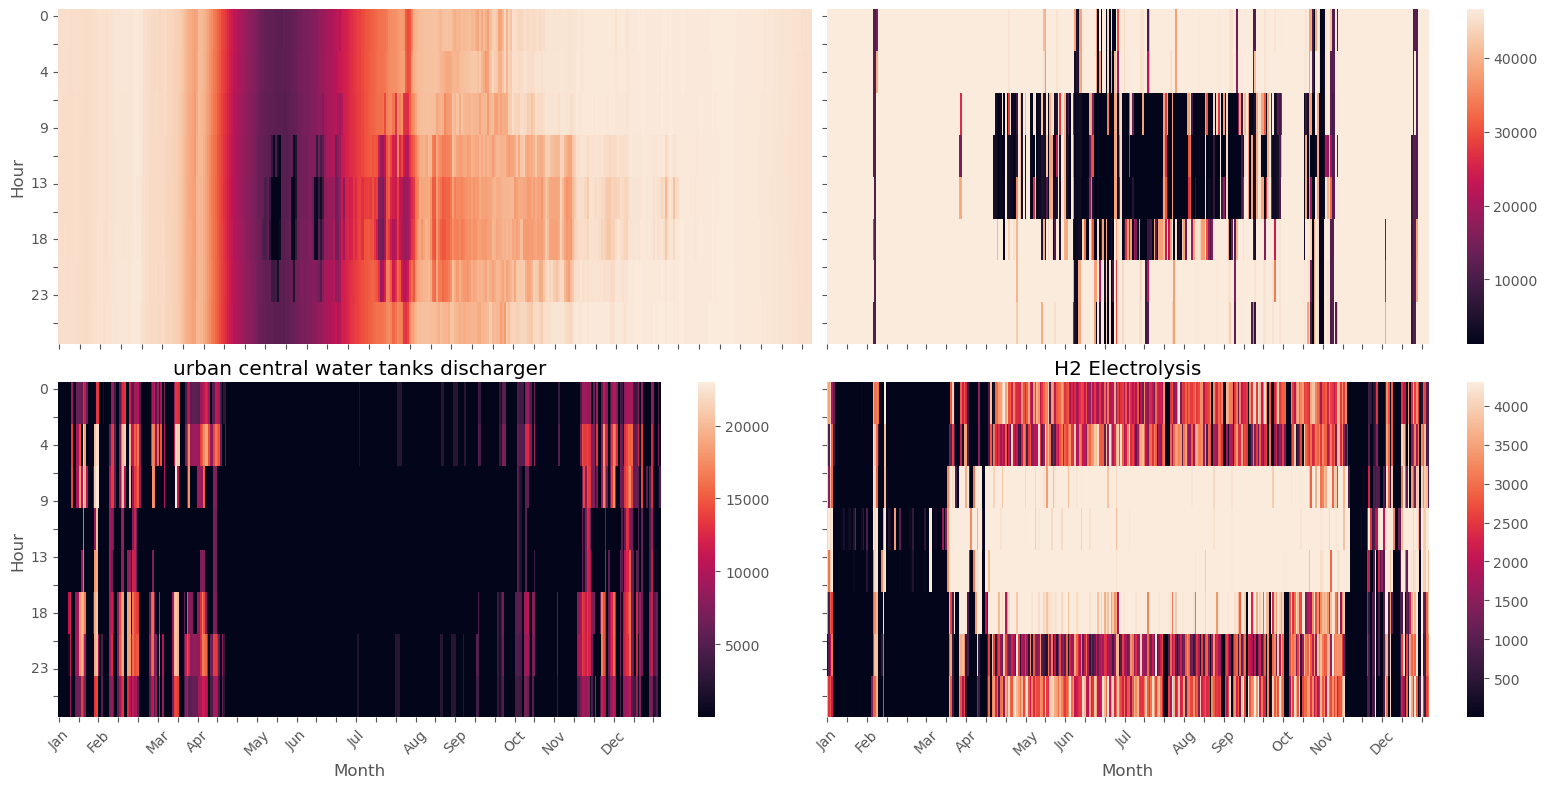

In [115]:
# print(model1.links.carrier.unique())
# carriers = ["geothermal"]
link_carriers = ['urban central water tanks discharger', 'H2 Electrolysis']

other_series = []
for carrier in link_carriers:
    idx = model1.links.index[
        (model1.links.carrier == carrier) &
        (model1.links.bus1.str[:5].isin(buses))
        ]
    other_series.append(model1.links_t.p0[idx].sum(axis=1))

injection_idx = model1.links.index[
    (model1.links.index.str.contains("injection well")) &
    (model1.links.bus1.str[:5].isin(buses))
    ]
production_idx = model1.links.index[
    (model1.links.index.str.contains("production well")) &
    (model1.links.bus1.str[:5].isin(buses))
    ]

# print(model1.links.loc[injection_idx].head())

def series_to_ax(series, ax, **plot_kwargs):
    new_index = pd.date_range(
        start=series.index[0],
        end=series.index[0] + pd.Timedelta(days=365) - pd.Timedelta(hours=1),
        freq="H",
        )
    new_series = series.reindex(new_index, method="ffill").reindex(new_index, method="bfill")
    values = new_series.values.reshape(-1, 24).T

    sns.heatmap(
        values,
        ax=ax,
        **plot_kwargs
    )

injection_series = (
    (series := model1.links_t.p0[injection_idx].sum(axis=1))
    #.mul(1/series.sum())
)
production_series = (
    (series := model1.links_t.p0[production_idx].sum(axis=1))
    #.mul(1/series.sum())
)

heatmap_kwargs = {
    "cbar": False
}

fig, axs = plt.subplots(1+len(link_carriers)//2, 2, figsize=(16, 4*(1+len(link_carriers)//2)))

months = [month[:3] for month in list(calendar.month_name)[1:]]

series_to_ax(injection_series, axs.flatten()[0], **heatmap_kwargs)
series_to_ax(production_series, axs.flatten()[1])

for series, carrier, ax in zip(other_series, link_carriers, axs.flatten()[2:]):
    series_to_ax(series, ax)
    ax.set_title(carrier)

for ax in axs.flatten()[1::2]:
    ax.set_yticklabels([])
for ax in axs.flatten()[:-2]:
    ax.set_xticklabels([])

for ax in axs.flatten()[-2:]:
    xlabels = ax.get_xticklabels()
    xlabels = ["" for _ in xlabels]

    for i, month in enumerate(months):
        xlabels[int(i * (len(xlabels)/12))] = month

    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xlabel("Month")

for ax in axs.flatten()[::2]:
    ylabels = ["" for _ in ax.get_yticklabels()]

    for i, hour in enumerate(np.linspace(0, 23, 6).astype(int)):
        ylabels[int(i * (24/len(ylabels)))] = hour

    ax.set_yticklabels(ylabels, rotation=0)
    ax.set_ylabel("Hour")

plt.tight_layout()
plt.show()

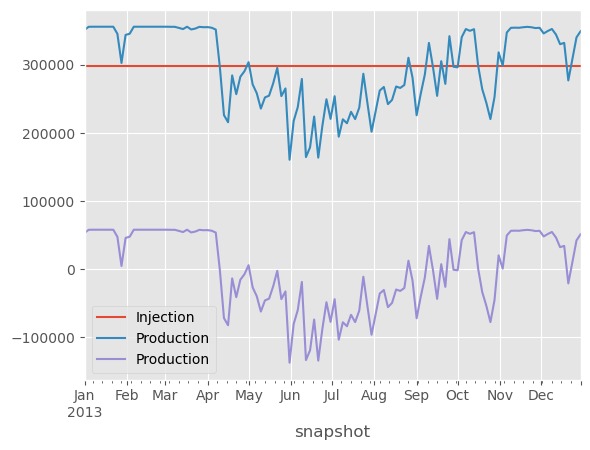

In [107]:
injection_series.resample("3d").mean().plot(label="Injection")
production_series.resample("3d").mean().plot(label="Production")
try:
    res_index = (idx := model1.df("StorageUnit").index)[idx.str.contains("geothermal storage")]
    resflow = (resflow := model1.pnl("StorageUnit")["p"][res_index]).sum(axis=1)
    resflow.resample("3d").mean().plot(label="Production")
except:
    pass
plt.legend()